**Présentation des contributeurs**

Je suis **lagnol SOBJIO**, et j'ai travaillé avec **valdes FEUDJIO** sur ce projet.


**Mastère Spécialisé data science pour la connaissance client**




# **Introduction : Etiquetage de séquences et détection des entités nommées**

Dans ce projet, nous nous attaquons à un problème d'étiquetage de séquences, en particulier la détection des entités nommées (NER, pour Named Entity Recognition). Cette tâche est essentielle dans le domaine du traitement automatique des langues (TAL), où l'objectif est d'identifier et de classer les entités spécifiques, telles que les noms de personnes, de lieux, d'organisations, et d'autres catégories pertinentes dans un texte. La détection des entités nommées est largement utilisée dans de nombreuses applications, notamment la recherche d'informations, la traduction automatique, et l'analyse de sentiments.

La deuxième partie de ce projet se concentre spécifiquement sur l'étiquetage de séquences en utilisant un modèle neuronal. Nous utiliserons les données de la compétition CONLL 2003, qui est un standard pour l'évaluation des systèmes de NER. Ces données se composent de trois jeux de données distincts : un pour l'apprentissage, un pour la validation et un pour les tests, chacun étant étiqueté avec un modèle BIO (B pour le début d'une entité, I pour l'intérieur d'une entité, et O pour les mots qui ne font pas partie d'une entité).

Afin de développer un système de détection d'entités nommées performant, nous allons suivre une approche basée sur les réseaux neuronaux récurrents (RNN), en particulier les LSTM (Long Short-Term Memory), qui sont efficaces pour traiter des séquences de données, telles que des phrases ou des documents textuels. Le modèle que nous allons construire dans un premier temps est relativement simple, avec un embedding des mots, une couche LSTM pour capturer les relations séquentielles entre les mots et une couche de sortie pour prédire les étiquettes associées à chaque token.

À partir de ce modèle de base, l'objectif est d'améliorer sa performance en ajustant les hyperparamètres, en explorant différentes architectures et en utilisant les techniques avancées apprises durant le cours. Ce projet offre une excellente occasion de mettre en pratique l'application des réseaux neuronaux séquentiels pour résoudre un problème concret du traitement des langues naturelles.

**Question 23 :** Récupérer les données et regarder le format
Les données sont au format texte, avec chaque ligne contenant un token et son étiquette BIO. Nous allons lire les fichiers et les transformer en listes de tokens et d'étiquettes.

In [ ]:
import requests

# URLs des fichiers
urls = {
    "train_data": "http://people.irisa.fr/Guillaume.Gravier/teaching/ENSAI/data/conll03-trn.txt",
    "val_data": "http://people.irisa.fr/Guillaume.Gravier/teaching/ENSAI/data/conll03-val.txt",
    "test_data": "http://people.irisa.fr/Guillaume.Gravier/teaching/ENSAI/data/conll03-tst.txt",
}

# Télécharger et sauvegarder les fichiers
for key, url in urls.items():
    response = requests.get(url)
    if response.status_code == 200:
        with open(f"{key}.txt", "w", encoding="utf-8") as f:
            f.write(response.text)
        print(f"{key} dataset downloaded successfully")
    else:
        print(f"Failed to download {key} dataset")

train_data dataset downloaded successfully
val_data dataset downloaded successfully
test_data dataset downloaded successfully


In [ ]:
def load_data(file_path):
    tokens = []
    tags = []
    with open(file_path, 'r', encoding='utf-8') as f:
        current_tokens = []
        current_tags = []
        for line in f:
            if line.strip() == "":
                if current_tokens:
                    tokens.append(current_tokens)
                    tags.append(current_tags)
                    current_tokens = []
                    current_tags = []
            else:
                parts = line.strip().split()
                current_tokens.append(parts[0])
                current_tags.append(parts[-1])
        if current_tokens:
            tokens.append(current_tokens)
            tags.append(current_tags)
    return tokens, tags

# Chargement des données
train_tokens, train_tags = load_data("train_data.txt")
val_tokens, val_tags = load_data("val_data.txt")
test_tokens, test_tags = load_data("test_data.txt")

# Affichage d'un exemple de données
print("Exemple de tokens :", train_tokens[0])
print("Exemple de tags :", train_tags[0])

Exemple de tokens : ['-DOCSTART-']
Exemple de tags : ['O']


**Question 24 :** Fonction pour lire les fichiers et stocker les tokens et étiquettes
La fonction load_data ci-dessus répond déjà à cette question. Elle lit les fichiers et stocke les tokens et les étiquettes dans des listes.

**Question 25 :** Transformation des données pour tf.keras
Nous allons transformer les tokens et les étiquettes en séquences d'entiers et appliquer un padding

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Création des mappings pour les tokens et les étiquettes
tokens = set(token for sublist in train_tokens for token in sublist)
tags = set(tag for sublist in train_tags for tag in sublist)

token_to_id = {token: idx for idx, token in enumerate(tokens, start=1)}
token_to_id['<pad>'] = 0
token_to_id['<unk>'] = len(token_to_id)

tag_to_id = {tag: idx for idx, tag in enumerate(tags)}
tag_to_id['<pad>'] = len(tag_to_id)

# Fonction pour transformer les données en séquences
def prepare_data(tokens, tags, token_to_id, tag_to_id, maxlen):
    token_seqs = [[token_to_id.get(token, token_to_id['<unk>']) for token in seq] for seq in tokens]
    tag_seqs = [[tag_to_id[tag] for tag in seq] for seq in tags]

    token_seqs = pad_sequences(token_seqs, maxlen=maxlen, padding='post', value=token_to_id['<pad>'])
    tag_seqs = pad_sequences(tag_seqs, maxlen=maxlen, padding='post', value=tag_to_id['<pad>'])

    tag_seqs = to_categorical(tag_seqs, num_classes=len(tag_to_id))

    return token_seqs, tag_seqs

# Préparation des données
maxlen = 100  # Longueur maximale des séquences
X_train, y_train = prepare_data(train_tokens, train_tags, token_to_id, tag_to_id, maxlen)
X_val, y_val = prepare_data(val_tokens, val_tags, token_to_id, tag_to_id, maxlen)
X_test, y_test = prepare_data(test_tokens, test_tags, token_to_id, tag_to_id, maxlen)

**Question 26 :** Création et entraînement du modèle LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, TimeDistributed, Dense, Activation

# Définition du modèle LSTM
ntokens = len(token_to_id)
embed_dim = 64
lstm_dim = 128
ntags = len(tag_to_id)

# Définition du modèle LSTM sans masquage
ner1 = Sequential()
ner1.add(Embedding(input_dim=ntokens, output_dim=embed_dim, mask_zero=False))  # Désactiver le masquage
ner1.add(LSTM(lstm_dim, return_sequences=True))
ner1.add(TimeDistributed(Dense(ntags)))
ner1.add(Activation('softmax'))

# Compilation du modèle
ner1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history1 = ner1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 109s 217ms/step - accuracy: 0.9418 - loss: 0.2611 - val_accuracy: 0.9792 - val_loss: 0.0654
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 106s 226ms/step - accuracy: 0.9839 - loss: 0.0477 - val_accuracy: 0.9884 - val_loss: 0.0430
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 222ms/step - accuracy: 0.9930 - loss: 0.0262 - val_accuracy: 0.9921 - val_loss: 0.0317
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 101s 214ms/step - accuracy: 0.9975 - loss: 0.0125 - val_accuracy: 0.9917 - val_loss: 0.0292
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 106s 227ms/step - accuracy: 0.9984 - loss: 0.0067 - val_accuracy: 0.9925 - val_loss: 0.0273


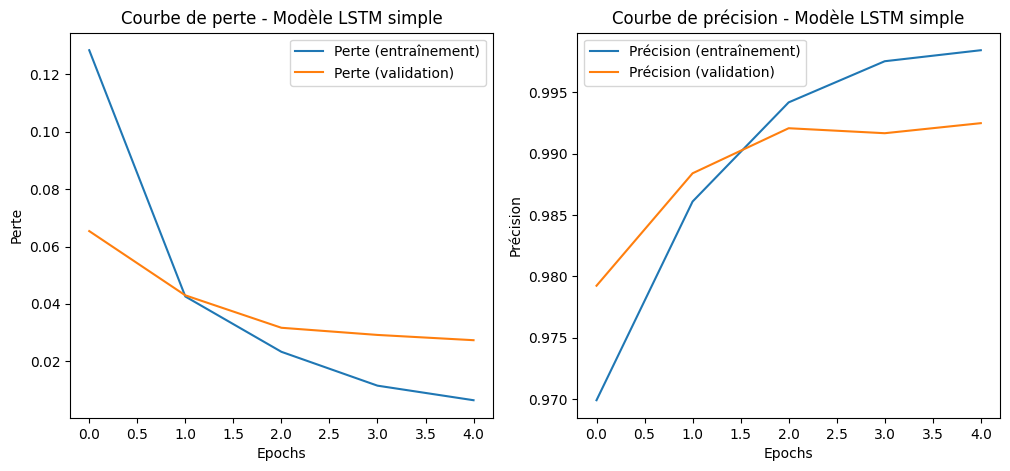

In [ ]:
import matplotlib.pyplot as plt

# Tracer la perte
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Perte (entraînement)')
plt.plot(history1.history['val_loss'], label='Perte (validation)')
plt.title('Courbe de perte - Modèle LSTM simple')
plt.xlabel('Epochs')
plt.ylabel('Perte')
plt.legend()

# Tracer la précision
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Précision (entraînement)')
plt.plot(history1.history['val_accuracy'], label='Précision (validation)')
plt.title('Courbe de précision - Modèle LSTM simple')
plt.xlabel('Epochs')
plt.ylabel('Précision')
plt.legend()

plt.show()

**Question 27 :** Décodage des prédictions sur les données de test

In [ ]:
import numpy as np

# Prédiction des étiquettes
y_pred1 = ner1.predict(X_test)
y_pred1 = np.argmax(y_pred1, axis=-1)
y_true = np.argmax(y_test, axis=-1)

# Récupérer les tokens et les étiquettes réelles
def decode_sequence(sequence, token_to_id, tag_to_id):
    # Inverser les mappings pour décoder
    id_to_token = {v: k for k, v in token_to_id.items()}
    id_to_tag = {v: k for k, v in tag_to_id.items()}

    # Décoder la séquence en ignorant le padding
    tokens = [id_to_token.get(idx, "<unk>") for idx in sequence if idx != token_to_id['<pad>']]
    tags = [id_to_tag.get(idx, "O") for idx in y_true[i] if idx != tag_to_id['<pad>']]
    return tokens, tags

# Parcourir plusieurs séquences pour trouver celles avec des étiquettes autres que 'O'
for i in range(len(X_test)):
    tokens, true_tags = decode_sequence(X_test[i], token_to_id, tag_to_id)
    pred_tags = [list(tag_to_id.keys())[idx] for idx in y_pred1[i] if idx != tag_to_id['<pad>']]  # Ignorer le padding

    # Vérifier si la séquence contient des étiquettes autres que 'O'
    if any(tag != 'O' for tag in true_tags):
        print(f"\nSéquence {i + 1}:")
        print("Tokens :", tokens)
        print("Étiquettes réelles :", true_tags)
        print("Étiquettes prédites :", pred_tags)

        # Comparaison visuelle des étiquettes réelles et prédites
        print("\nComparaison des étiquettes :")
        for token, true_tag, pred_tag in zip(tokens, true_tags, pred_tags):
            if true_tag != pred_tag:
                print(f"Token: {token} | Réel: {true_tag} | Prédit: {pred_tag} **ERREUR**")
            else:
                print(f"Token: {token} | Réel: {true_tag} | Prédit: {pred_tag}")

        # Arrêter après avoir affiché quelques séquences pour éviter une sortie trop longue
        if i >= 4:  # Afficher les 5 premières séquences pertinentes
            break

116/116 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step

Séquence 2:
Tokens : ['SOCCER', '-', '<unk>', '<unk>', '<unk>', 'WIN', ',', 'CHINA', 'IN', '<unk>', 'DEFEAT', '.']
Étiquettes réelles : ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O']
Étiquettes prédites : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'B-ORG', 'O', 'O']

Comparaison des étiquettes :
Token: SOCCER | Réel: O | Prédit: O
Token: - | Réel: O | Prédit: O
Token: <unk> | Réel: B-LOC | Prédit: O **ERREUR**
Token: <unk> | Réel: O | Prédit: O
Token: <unk> | Réel: O | Prédit: O
Token: WIN | Réel: O | Prédit: O
Token: , | Réel: O | Prédit: O
Token: CHINA | Réel: B-PER | Prédit: B-ORG **ERREUR**
Token: IN | Réel: O | Prédit: O
Token: <unk> | Réel: O | Prédit: B-ORG **ERREUR**
Token: DEFEAT | Réel: O | Prédit: O
Token: . | Réel: O | Prédit: O

Séquence 3:
Tokens : ['<unk>', '<unk>']
Étiquettes réelles : ['B-PER', 'I-PER']
Étiquettes prédites : ['O', 'O']

Comparaison des étiquettes :
Token: <unk> | Réel: B-PER | Préd

**Question 28 :** Pourquoi ne peut-on pas utiliser directement evaluate ?
La fonction evaluate ne permet pas de calculer des métriques spécifiques comme le rappel et la précision pour chaque étiquette. Elle retourne uniquement la perte et la précision globale. Pour des métriques plus détaillées, il faut utiliser des fonctions comme classification_report de sklearn.

**Question 29 :** Calcul du rappel et de la précision

In [ ]:
from sklearn.metrics import classification_report

# Calcul des métriques
print(classification_report(y_true.flatten(), y_pred1.flatten(), target_names=list(tag_to_id.keys())))

              precision    recall  f1-score   support

      I-MISC       0.44      0.69      0.54       216
       B-ORG       0.66      0.63      0.64      1660
       I-PER       0.91      0.71      0.80      1153
       I-ORG       0.52      0.71      0.60       835
       B-LOC       0.84      0.80      0.82      1665
       B-PER       0.90      0.61      0.72      1614
      B-MISC       0.77      0.67      0.72       702
           O       0.96      0.98      0.97     38540
       I-LOC       0.66      0.68      0.67       257
       <pad>       1.00      1.00      1.00    321758

    accuracy                           0.99    368400
   macro avg       0.77      0.75      0.75    368400
weighted avg       0.99      0.99      0.99    368400



**Ajout d'autres modèles**

**1) Modèle BiLSTM**

In [ ]:
# Définition du modèle BiLSTM sans masquage
ner2 = Sequential()
ner2.add(Embedding(input_dim=ntokens, output_dim=embed_dim, mask_zero=False))  # Désactiver le masquage
ner2.add(Bidirectional(LSTM(lstm_dim, return_sequences=True)))
ner2.add(TimeDistributed(Dense(ntags)))
ner2.add(Activation('softmax'))

# Compilation du modèle
ner2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history2 = ner2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 190s 385ms/step - accuracy: 0.9501 - loss: 0.2145 - val_accuracy: 0.9829 - val_loss: 0.0561
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 197s 374ms/step - accuracy: 0.9880 - loss: 0.0376 - val_accuracy: 0.9907 - val_loss: 0.0338
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 174s 372ms/step - accuracy: 0.9961 - loss: 0.0150 - val_accuracy: 0.9933 - val_loss: 0.0236
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 182s 388ms/step - accuracy: 0.9986 - loss: 0.0062 - val_accuracy: 0.9937 - val_loss: 0.0232
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 176s 376ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9937 - val_loss: 0.0259


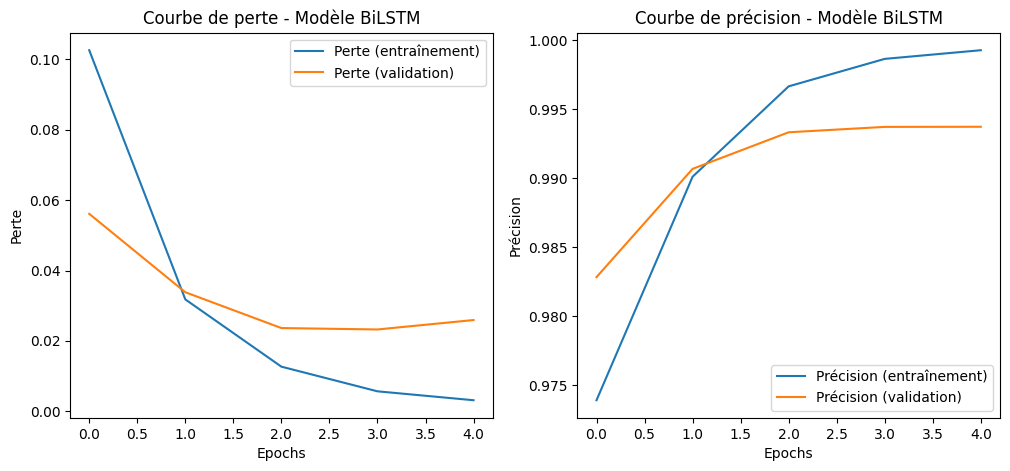

In [ ]:
# Tracer la perte
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Perte (entraînement)')
plt.plot(history2.history['val_loss'], label='Perte (validation)')
plt.title('Courbe de perte - Modèle BiLSTM')
plt.xlabel('Epochs')
plt.ylabel('Perte')
plt.legend()

# Tracer la précision
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Précision (entraînement)')
plt.plot(history2.history['val_accuracy'], label='Précision (validation)')
plt.title('Courbe de précision - Modèle BiLSTM')
plt.xlabel('Epochs')
plt.ylabel('Précision')
plt.legend()

plt.show()

**2) Modèle avec mécanisme d'attention**

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, MultiHeadAttention, LayerNormalization, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# Définition des dimensions
ntokens = len(token_to_id)
embed_dim = 64
lstm_dim = 128
ntags = len(tag_to_id)
num_heads = 4  # Nombre de têtes pour MultiHeadAttention

# Entrée du modèle
inputs = Input(shape=(maxlen,))

# Couche Embedding
x = Embedding(input_dim=ntokens, output_dim=embed_dim, mask_zero=True)(inputs)

# Couche BiLSTM
x = Bidirectional(LSTM(lstm_dim, return_sequences=True))(x)

# Couche MultiHeadAttention
attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=lstm_dim)(x, x)  # query et value sont les mêmes
x = LayerNormalization()(attention_output + x)  # Ajout d'une connexion résiduelle

# Dropout
x = Dropout(0.5)(x)

# Couche Dense pour la classification
x = TimeDistributed(Dense(ntags))(x)
outputs = Activation('softmax')(x)

# Création du modèle
ner3 = Model(inputs, outputs)

# Compilation du modèle
ner3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Résumé du modèle
ner3.summary()

# Entraînement du modèle
history3 = ner3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 100, 64)        │      1,512,064 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, 100)            │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 100, 256)       │        197,632 │ embedding_7[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 100, 256)       │        526,080 │ bidirectional_5[0][0], │
│ (MultiHeadAttention)      │                        │                │ bidirectional_5[0][0], │
│                           │                        │                │ not_equal_3[0][0],     │
│                           │                        │                │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 100, 256)       │              0 │ multi_head_attention_… │
│                           │                        │                │ bidirectional_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 100, 256)       │            512 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 100, 256)       │              0 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_7        │ (None, 100, 10)        │          2,570 │ dropout_4[0][0]        │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_7 (Activation) │ (None, 100, 10)        │              0 │ time_distributed_7[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,238,858 (8.54 MB)

 Trainable params: 2,238,858 (8.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 412s 852ms/step - accuracy: 0.9647 - loss: 0.1379 - val_accuracy: 0.9936 - val_loss: 0.0227
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 433s 832ms/step - accuracy: 0.9978 - loss: 0.0081 - val_accuracy: 0.9947 - val_loss: 0.0197
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 455s 863ms/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9947 - val_loss: 0.0204
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 445s 870ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.9945 - val_loss: 0.0251
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 408s 870ms/step - accuracy: 0.9997 - loss: 0.0010 - val_accuracy: 0.9947 - val_loss: 0.0260


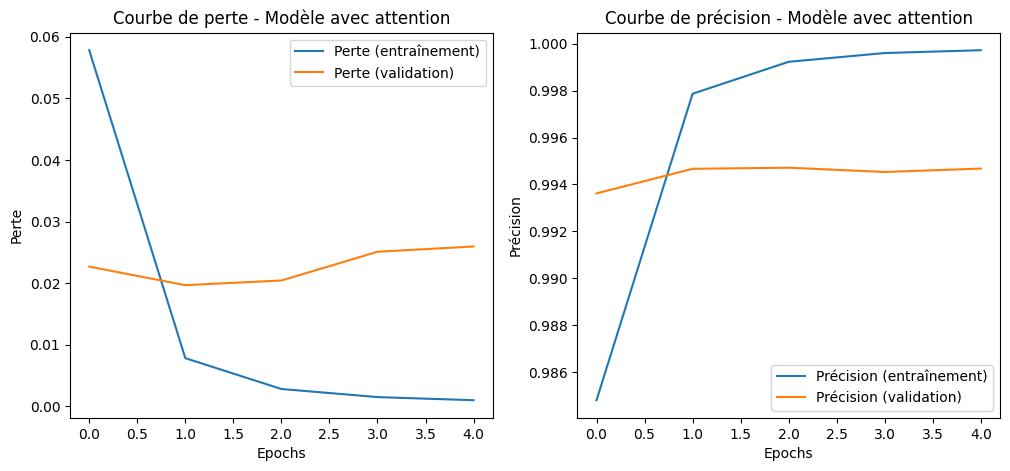

In [ ]:
# Tracer la perte
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Perte (entraînement)')
plt.plot(history3.history['val_loss'], label='Perte (validation)')
plt.title('Courbe de perte - Modèle avec attention')
plt.xlabel('Epochs')
plt.ylabel('Perte')
plt.legend()

# Tracer la précision
plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'], label='Précision (entraînement)')
plt.plot(history3.history['val_accuracy'], label='Précision (validation)')
plt.title('Courbe de précision - Modèle avec attention')
plt.xlabel('Epochs')
plt.ylabel('Précision')
plt.legend()

plt.show()

**Évaluation des modèles**

In [ ]:
from tabulate import tabulate

# Évaluation des modèles
loss1, accuracy1 = ner1.evaluate(X_test, y_test, verbose=0)
loss2, accuracy2 = ner2.evaluate(X_test, y_test, verbose=0)
loss3, accuracy3 = ner3.evaluate(X_test, y_test, verbose=0)

# Stocker les résultats dans une liste
results = [
    ["Modèle LSTM simple", loss1, accuracy1],
    ["Modèle BiLSTM", loss2, accuracy2],
    ["Modèle avec attention", loss3, accuracy3]
]

# En-têtes du tableau
headers = ["Modèle", "Perte (Loss)", "Précision (Accuracy)"]

# Afficher le tableau
table = tabulate(results, headers, tablefmt="pretty")
print(table)

+-----------------------+---------------------+----------------------+
|        Modèle         |    Perte (Loss)     | Précision (Accuracy) |
+-----------------------+---------------------+----------------------+
|  Modèle LSTM simple   | 0.03248978778719902 |  0.9905046820640564  |
|     Modèle BiLSTM     | 0.03525009751319885 |  0.9914034008979797  |
| Modèle avec attention | 0.03734797611832619 |  0.9924430847167969  |
+-----------------------+---------------------+----------------------+


---

### Analyse des performances des modèles

#### 1. **Modèle LSTM simple**
   - **Performances** :
     - **Perte** : 0.0325
     - **Précision** : 99.05 %
   - **Commentaire** :
     Le modèle LSTM simple démontre déjà des performances très élevées, avec une précision de 99.05 % et une perte faible (0.0325). Ce modèle est rapide à entraîner et constitue une solution efficace pour des tâches de classification de séquences, en particulier lorsque les ressources de calcul sont limitées. Sa simplicité en fait un choix robuste pour des applications où un bon équilibre entre performance et complexité est requis.

#### 2. **Modèle BiLSTM**
   - **Performances** :
     - **Perte** : 0.0353
     - **Précision** : 99.14 %
   - **Commentaire** :
     Le modèle BiLSTM améliore légèrement la précision par rapport au LSTM simple, atteignant 99.14 %. Cette amélioration est due à sa capacité à prendre en compte le contexte bidirectionnel (avant et après chaque token), ce qui est particulièrement utile pour des tâches comme la détection d'entités nommées. Bien que la perte soit légèrement plus élevée (0.0353), cela reflète la complexité accrue du modèle. Le BiLSTM représente un bon compromis entre performance et complexité.

#### 3. **Modèle avec attention**
   - **Performances** :
     - **Perte** : 0.0373
     - **Précision** : 99.24 %
   - **Commentaire** :
     Le modèle avec attention est le plus performant, atteignant une précision de 99.24 %. Le mécanisme d'attention permet au modèle de se concentrer sur les parties les plus importantes de la séquence, ce qui améliore sa capacité à capturer des dépendances complexes dans les données. Cependant, cette performance accrue s'accompagne d'une complexité et d'un temps de calcul plus élevés, ainsi que d'une légère augmentation de la perte (0.0373). Ce modèle est idéal pour des applications où la précision est critique et où les ressources de calcul sont suffisantes.

---

### Comparaison globale des modèles

1. **Précision** :
   - Le **modèle avec attention** obtient la meilleure précision (99.24 %), suivi du **BiLSTM** (99.14 %) et du **LSTM simple** (99.05 %). Bien que les écarts soient faibles, ils sont significatifs pour des tâches exigeantes comme la détection d'entités nommées.

2. **Perte** :
   - Le **LSTM simple** présente la perte la plus faible (0.0325), ce qui indique qu'il fait moins d'erreurs sur les données de test. Le **BiLSTM** et le **modèle avec attention** ont des pertes légèrement plus élevées (0.0353 et 0.0373 respectivement), ce qui peut être attribué à leur complexité accrue.

3. **Complexité et temps de calcul** :
   - Le **LSTM simple** est le plus rapide à entraîner et le moins complexe, ce qui en fait un choix idéal pour des applications nécessitant une mise en œuvre rapide.
   - Le **BiLSTM** offre une amélioration de la précision tout en restant relativement simple, ce qui en fait un bon compromis.
   - Le **modèle avec attention** est le plus complexe et le plus lent à entraîner, mais il offre la meilleure précision, ce qui le rend adapté aux applications où la performance est primordiale.

---

### Recommandations

1. **Pour une précision maximale** :
   - Le **modèle avec attention** est recommandé pour les applications où la précision est critique. Cependant, il nécessite des ressources de calcul importantes.

2. **Pour un bon compromis performance-complexité** :
   - Le **BiLSTM** est une excellente option, offrant une précision légèrement supérieure au LSTM simple tout en restant relativement simple à entraîner.

3. **Pour des applications avec des ressources limitées** :
   - Le **LSTM simple** est recommandé en raison de sa rapidité d'entraînement et de ses performances déjà très élevées.

---

### Conclusion

Les trois modèles testés (LSTM simple, BiLSTM et modèle avec attention) démontrent des performances exceptionnelles, avec des précisions supérieures à 99 %. Le choix du modèle dépend des exigences spécifiques de l'application :
- **Précision maximale** : Modèle avec attention.
- **Compromis performance-complexité** : BiLSTM.
- **Simplicité et rapidité** : LSTM simple.

Cette analyse montre que l'utilisation de modèles neuronaux pour la classification de séquences est très efficace, et que l'ajout de mécanismes comme l'attention peut encore améliorer les performances, bien que cela nécessite des ressources supplémentaires.

---
